
### **시작하기 전, mount 및 경로 변경, 패키지 import**

In [40]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [41]:
import os 
os.chdir('/content/drive/MyDrive/Colab Notebooks/lstm')

In [42]:
import tensorflow as tf
print(tf.__version__)
import torch
print(torch.cuda.is_available())
# print(torch.cuda.current_device())
# print(torch.cuda.get_device_name(0))
torch.cuda.device(0)
# cuda = torch.device('cuda')


2.8.2
False


In [6]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [43]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from attention import AttentionLayer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import nltk
nltk.download('stopwords')
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Data Preprocessing** 

In [51]:
# 판다로 불러오기 1950- 2019 빌보트 차트 가사.
data = pd.read_csv("./tcc_ceds_music.csv")

In [52]:
# 반복된 행, null 행 제거

data = data[["lyrics", "track_name"]]
data.drop_duplicates(subset=['track_name'],inplace=True)
data.dropna(axis=0,inplace=True)
data

,lyrics,track_name
0,hold time feel break feel untrue convince speak voice tear try hold hurt try forgive okay play break string feel heart want feel tell real truth hurt lie worse anymore little turn dust play house ...,mohabbat bhi jhoothi
1,believe drop rain fall grow believe darkest night candle glow believe go astray come believe believe believe smallest prayer hear believe great hear word time hear bear baby touch leaf believe bel...,i believe
2,sweetheart send letter goodbye secret feel better wake dream think real false emotions feel heartaches hang long blue get bluer song remember cloudy hair,cry
3,kiss lips want stroll charm mambo chacha meringue heaven arm japan brag geisha care long uncle eye starry sort gleam like million dollar dream come true everybody wish steal heart away guess try e...,patricia
4,till darling till matter know till dream live apart know hearts till world free oceans cross mountains climb know gain loss pray loss time till dream till memory till hold till oceans cross mounta...,apopse eida oneiro
...,...,...
28367,cause fuck leave scar tick tock clock come knock door wish like genie strait pay stack loot slangin dope mammas house grade try tiots looter hang drive shooters stickem honda scooters schollar thr...,10 million ways
28368,minks things chain ring braclets yap fame come fool want stiflin fool fool want life jewel rule thing clap respect brooklyn bind bind brownsville home brave work street like slave rugged dress cod...,ante up (robbin hoodz theory)
28369,get ban get ban stick crack relax plan attack test pose finesse buddha bless nest chill peep steady bounce jeeps york streets hittin concrete untestable flow fiftyfix celo ounce bottle follow role...,whutcha want?
28370,check check yeah yeah hear thing call switch go switch turn turn switch turn vibe vibe second club girl arrive neckid hear veteran glide record download record sexy bout girl floor friends mean re...,switch


In [53]:
# 복잡한 축약어를 풀어 쓰기 위함.

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [54]:
# 불용어 
stop_words = set(stopwords.words('english')) 

# text_cleaner, 
def text_cleaner(text,num):
    newString = text.lower() # lower
    newString = re.sub(r'\([^)]*\)', '', newString) # Remove any text inside the parenthesis
    newString = re.sub('"','', newString) # remove double quotes
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])  # contraction mapping
    newString = re.sub(r"'s\b","",newString) # remove 's
    newString = re.sub("[^a-zA-Z]", " ", newString) # Eliminate punctuations and special characters
    if(num==0) : tokens = [w for w in newString.split() if not w in stop_words] # Remove stopwords
    else : tokens=newString.split()
    long_words=[]
    for i in tokens: # Remove short words
        if len(i)>1:                                                 
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [55]:
cleaned_lyrics = []
for t in data['lyrics']:
    cleaned_lyrics.append(text_cleaner(t,0))

cleaned_titles = []
for t in data['track_name']:
    cleaned_titles.append(text_cleaner(t,0))
  
data['cleaned_lyrics']=cleaned_lyrics
data['cleaned_titles']=cleaned_titles

data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)
data
    

In [107]:

pred = pd.read_csv('./predicted title.csv')

# print(data[data.cleaned_titles == 'guess'].track_name)
# data
# pred['original titles'].values[1]
# pred

for a in pred['original titles'].values : 
  print(data[data.cleaned_titles == a[:-1]]['track_name'].values)
  if (data[data.cleaned_titles == a[:-1]]['track_name'].values == []) : 
    print(a[:-1])
    print(data[data.cleaned_titles == a[:-1]]['track_name'].values)
    break
  # else : pred['real title'] = data[data.cleaned_titles == a[:-1]].track_name.values[0]

pred


# a = "abcd "
# a[:-2]

['guess who' 'guess it’s all over']
['roads' 'all my roads']
['lonely and gone']
['you never really wanted me']
['naked sunday']
['highway 377']
['shout sister shout']
['same man i was before' '6 man' 'here was a man' 'the man'
 "you're my man" 'her man' "the man that i've been" "i'm just a man"
 'i’ll be your man (song for a daughter)' 'only a man' 'your man' 'mané'
 "i'm a man" "i'm the man"]
['we can and shall']
[]
['morning in america']
['oh me, oh my, sweet baby']
['autumn']
['bye bye bird']
['on the radio' 'on your radio' 'radio' 'am radio']
['a real good place to start']
["you're gonna lose your gal"]
['hold out' 'hold me now' 'hold me (with teddy pendergrass)' 'hold on'
 'hold me down' 'hold on to me' "i'll just hold on"
 'hold on (i feel our love is changing)' 'hold up' 'hold it down'
 'if i can’t hold you' 'hold me' 'hold you' 'hold me (feat. tobymac)'
 'hold you down']
[]
['the 15th' '18th & m']
['never say goodbye' 'never can say goodbye']
["when i'm small"]
['i follow rive

,Unnamed: 0,predicted titles,original titles
0,0,love,guess
1,1,love,roads
2,2,love,lonely gone
3,3,love,never really wanted
4,4,love,naked sunday
...,...,...,...
1733,1733,love,running back
1734,1734,love,big enough
1735,1735,love,gonna kill
1736,1736,love,sing love song


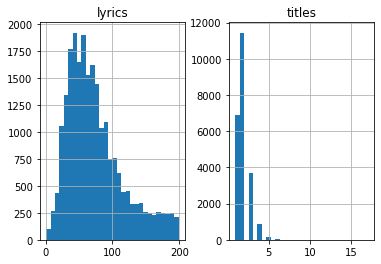

In [22]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_lyrics']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_titles']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'lyrics':text_word_count, 'titles':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [23]:
# lyrics 최대 길이
print(length_df.sort_values('lyrics', ascending = False)['lyrics'].head(1).values[0])
# titles 최대 길이
print(length_df.sort_values('titles', ascending = False)['titles'].head(5).values[0])

199
17


In [24]:
# 적당한 input, output 크기 찾기

cnt=0
for i in data['cleaned_lyrics']:
    if(len(i.split()) <= 150):
        cnt=cnt+1
print(cnt/len(data['cleaned_lyrics']))

cnt=0
for i in data['cleaned_titles']:
    if(len(i.split()) <= 10):
        cnt=cnt+1
print(cnt/len(data['cleaned_titles']))

# output 크기 = 10
# input 크기 = 150

0.9229373650107991
0.9998704103671706


In [25]:
max_text_len=150
max_summary_len=10

In [26]:
# Let us select the reviews and summaries whose length falls below or equal to max_text_len and max_summary_len

cleaned_lyrics =np.array(data['cleaned_lyrics'])
cleaned_titles =np.array(data['cleaned_titles'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_lyrics)):
    if(len(cleaned_lyrics[i].split())<=max_text_len and len(cleaned_titles[i].split())<=max_summary_len):
        short_text.append(cleaned_lyrics[i])
        short_summary.append(cleaned_titles[i])
        
df=pd.DataFrame({'lyrics':short_text,'title':short_summary}) # new dataframe to use

df['title'] = df['title'].apply(lambda x : 'sostok '+ x + ' eostok')
df.head()


,lyrics,title
0,hold time feel break feel untrue convince speak voice tear try hold hurt try forgive okay play break string feel heart want feel tell real truth hurt lie worse anymore little turn dust play house ...,sostok mohabbat bhi jhoothi eostok
1,believe drop rain fall grow believe darkest night candle glow believe go astray come believe believe believe smallest prayer hear believe great hear word time hear bear baby touch leaf believe bel...,sostok believe eostok
2,sweetheart send letter goodbye secret feel better wake dream think real false emotions feel heartaches hang long blue get bluer song remember cloudy hair,sostok cry eostok
3,kiss lips want stroll charm mambo chacha meringue heaven arm japan brag geisha care long uncle eye starry sort gleam like million dollar dream come true everybody wish steal heart away guess try e...,sostok patricia eostok
4,till darling till matter know till dream live apart know hearts till world free oceans cross mountains climb know gain loss pray loss time till dream till memory till hold till oceans cross mounta...,sostok apopse eida oneiro eostok


### **Train-Test Split and Prepare the Tokenizer**

In [ ]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['lyrics']), np.array(df['title']),
                                       test_size=0.1, random_state=0, shuffle=True) 

# A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.
# We will now build tokenizers for text and summary.

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

import torch
example_token = x_tokenizer.texts_to_sequences(x_tr[4:5])
print(example_token)
a = torch.tensor(example_token)
print(a.shape)

[[5584, 66, 3980, 684, 18, 9, 18, 9, 110, 2, 18, 9, 18, 9, 5124, 18, 9, 293, 18, 9, 293, 18, 9, 5124, 18, 9, 10764, 1444, 209, 641, 14, 1345, 103, 6, 31, 1444, 1444, 10764, 1444, 496, 217, 850, 8, 188, 3, 112, 474, 217, 850, 953, 20, 641, 10764, 1444, 243, 19, 288, 52, 389, 389, 15, 10764, 1444, 1, 165, 1422, 40, 42, 772, 2, 18, 9, 293, 18, 9, 110, 2, 18, 9, 18, 9, 5124]]
torch.Size([1, 82])


### **Rarewords and its Coverage on Lyrics column**

In [ ]:
thresh=4
# 4번 이하로 나오는 word를 rareword로 지칭함.

cnt=0
tot_cnt=0
freq=0
tot_freq=0
# tot_cnt는 전체 word의 수
# cnt는 전체 word 중 rareword의 수

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 65.51304732419283
Total Coverage of rare words: 2.642650126885452


In [ ]:
print(cnt)
print(tot_cnt)

23700
36176


In [ ]:
print(freq)
print(tot_freq)

33719
1275954


### **Lyrics Tokenizer**


In [ ]:
# prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

12477

### **Title Tokenizer**

In [ ]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


% of rare words in vocabulary: 80.35356511490866
Total Coverage of rare words: 11.925538863487917


In [ ]:
print(cnt),print(tot_cnt)
print(freq),print(tot_freq)

6818
8485
9129
76550


(None, None)

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
y_voc


1668

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)


In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)


In [ ]:
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)


tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
latent_dim = 300
embedding_dim=100

with tf.device('/gpu:0'): 
    # Encoder
    encoder_inputs = Input(shape=(max_text_len,))

    #embedding layer
    enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

    #encoder lstm 1
    encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

    #encoder lstm 2
    encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

    #encoder lstm 3
    encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
    encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None,))

    #embedding layer
    dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
    dec_emb = dec_emb_layer(decoder_inputs)

    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
    decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

    #dense layer
    decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model 
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.summary() 

    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
    # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

    history=model.fit([x_tr, y_tr[:,:-1]], 
                    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                    epochs=50,
                    # callbacks=[es],
                    batch_size=256, 
                    validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                  )


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 150, 100)     1247700     ['input_6[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  [(None, 150, 300),   481200      ['embedding_2[0][0]']            
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                            

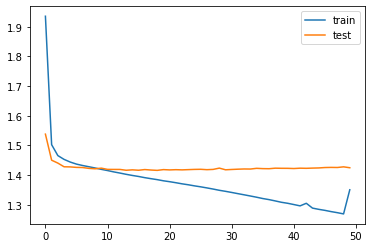

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index


In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString


In [ ]:
lstm_predicted = []
original_title = []


for i in range(0, len(x_tr)):
    print(i)
    lstm_predicted.append(decode_sequence(x_tr[i].reshape(1,max_text_len)))
    original_title.append(seq2summary(y_tr[i]))
lstm_predicted = pd.DataFrame(lstm_predicted, columns = ['predicted titles'])
original_title = pd.DataFrame(original_title, columns = ['original titles'])

final_tr = pd.concat([lstm_predicted, original_title], axis = 1)
final_tr.to_csv('./predicted title_train.csv')


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957
8958
8959
8960
8961
8962
8963
8964
8965
8966
8967
8968

In [ ]:
lstm_predicted = []
original_title = []


for i in range(0, len(x_val)):
    print(i)
    lstm_predicted.append(decode_sequence(x_val[i].reshape(1,max_text_len)))
    original_title.append(seq2summary(y_val[i]))
lstm_predicted = pd.DataFrame(lstm_predicted, columns = ['predicted titles'])
original_title = pd.DataFrame(original_title, columns = ['original titles'])

final_val = pd.concat([lstm_predicted, original_title], axis = 1)
final_val.to_csv('./predicted title.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
final_val

,predicted titles,original titles
0,love,guess
1,love,roads
2,love,lonely gone
3,love,never really wanted
4,love,naked sunday
...,...,...
1733,love,running back
1734,love,big enough
1735,love,gonna kill
1736,love,sing love song
